In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tse-spacy-model/models2/model_neg/tokenizer
/kaggle/input/tse-spacy-model/models2/model_neg/meta.json
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/vectors
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/key2row
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/lexemes.bin
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/strings.json
/kaggle/input/tse-spacy-model/models2/model_neg/ner/model
/kaggle/input/tse-spacy-model/models2/model_neg/ner/moves
/kaggle/input/tse-spacy-model/models2/model_neg/ner/cfg
/kaggle/input/tse-spacy-model/models/model_neg/tokenizer
/kaggle/input/tse-spacy-model/models/model_neg/meta.json
/kaggle/input/tse-spacy-model/models/model_neg/vocab/vectors
/kaggle/input/tse-spacy-model/models/model_neg/vocab/key2row
/kaggle/input/tse-spacy-model/models/model_neg/vocab/le

**Import and Install Dependencies**

In [2]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.express as px
import plotly.figure_factory as ff

from PIL import Image

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [4]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
#since we have only one value which is null we can remove it
train.dropna(inplace= True)

In [7]:
test.info()
# there is no null values in test df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [8]:
train.groupby('sentiment').count()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11117,11117,11117
positive,8582,8582,8582


<Axes: xlabel='sentiment', ylabel='Count'>

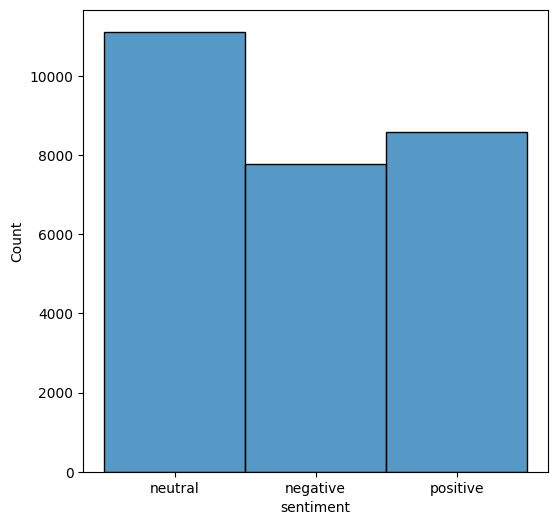

In [9]:
plt.figure(figsize=(6,6))
sns.histplot(data=train,x='sentiment')

In [10]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by= 'text',ascending= False)

In [11]:
temp

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


**Generating Meta Features**

In [12]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c))/(len(a)+len(b)-len(c))

In [13]:
results_jaccard=[]
for ind,row in train.iterrows():
    sentence1= row.text
    sentence2= row.selected_text
    
    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [14]:
jaccard = pd.DataFrame(results_jaccard,columns = ["text", "selected_text", "jaccard_score"])
train = train.merge(jaccard, how='outer')   

In [15]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.200000
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.166667
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.222222
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.666667
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.181818


In [16]:
train.replace({'sentiment':{'negative':0,'neutral':1,'positive':2}},inplace = True)
#replace negative-- 0, neutral --1, positive -- 2

In [17]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,0,0.200000
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,2,0.166667
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,0,0.222222
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,1,0.666667
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,2,0.181818


In [18]:
train.groupby('sentiment').count()

,textID,text,selected_text,jaccard_score
sentiment,,,,
0,7781,7781,7781,7781
1,11117,11117,11117,11117
2,8582,8582,8582,8582


In [19]:
#repeat in test also

In [20]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [21]:
test.replace({'sentiment':{'negative':0,'neutral':1,'positive':2}},inplace = True)
#replace negative-- 0, neutral --1, positive -- 2

In [22]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1
1,96d74cb729,Shanghai is also really exciting (precisely -...,2
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0
3,01082688c6,happy bday!,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2


In [23]:
test.groupby('sentiment').count()

,textID,text
sentiment,,
0,1001,1001
1,1430,1430
2,1103,1103


#### Stemming ---reducing a word to its Root word

In [24]:
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [25]:
ps = PorterStemmer()

In [26]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('\[.*?\]','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    
    return text

In [27]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,0,0.200000
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,2,0.166667
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,0,0.222222
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,1,0.666667
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,2,0.181818


In [28]:
train['cleaned_text'] = train['text'].apply(lambda x: clean_text(x))

In [29]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,cleaned_text
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,0,0.200000,\treally oh sorry yall lol
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,2,0.166667,beckett thanks so much
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,0,0.222222,youll be missed bring me back a keychain
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,1,0.666667,get lit i am
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,2,0.181818,good morning to you its so pretty outsi...


In [30]:
def stemming(text):
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    
    return text
        
        
        
      

In [31]:
train['stemmed_text'] = train['cleaned_text'].apply(lambda x: stemming(x))

In [32]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,cleaned_text,stemmed_text
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,0,0.200000,\treally oh sorry yall lol,realli oh sorri yall lol
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,2,0.166667,beckett thanks so much,beckett thank much
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,0,0.222222,youll be missed bring me back a keychain,youll miss bring back keychain
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,1,0.666667,get lit i am,get lit
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,2,0.181818,good morning to you its so pretty outsi...,good morn pretti outsid today


In [33]:
#seprating the data and label
X = train['stemmed_text'].values

In [34]:
y= train['sentiment'].values

In [35]:
y

array([0, 2, 0, ..., 2, 1, 1])

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=2)

In [37]:
X_test.shape

(5496,)

#### Text to Vector

**TfIdf**

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(max_features=2500,ngram_range=(1,2))
X_train = tv.fit_transform(X_train)

X_test = tv.transform(X_test)

In [39]:
print(X_train)

  (0, 2188)	0.5326848979717773
  (0, 583)	0.41865741549351326
  (0, 714)	0.48001695434678754
  (0, 865)	0.23798457264238307
  (0, 2185)	0.29222723392900346
  (0, 1249)	0.2966955722097959
  (0, 577)	0.2837160831363822
  (1, 2212)	0.34095623725938357
  (1, 1976)	0.5628598034800784
  (1, 385)	0.4275823616333883
  (1, 1404)	0.5725757355096576
  (1, 865)	0.2372088468541585
  (2, 95)	0.5089039985495529
  (2, 668)	0.49617202922678133
  (2, 1083)	0.3746659719244047
  (2, 898)	0.25230170886819714
  (2, 756)	0.37223635003276545
  (2, 997)	0.39017867006240603
  (3, 178)	0.4973538806270904
  (3, 533)	0.5656277409988381
  (3, 2399)	0.5463903060943894
  (3, 1337)	0.3662813255460954
  (4, 2132)	1.0
  (5, 2367)	0.4726680596910615
  (5, 1240)	0.42091669920057445
  :	:
  (21979, 1369)	1.0
  (21980, 32)	0.439883767886772
  (21980, 1644)	0.4353068683603797
  (21980, 1702)	0.5712520460602676
  (21980, 1750)	0.3918117337475809
  (21980, 920)	0.28427985241729375
  (21980, 488)	0.2373811951003912
  (21981, 18

**Traing the model**

In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter= 1000,multi_class='multinomial')
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

**Model Evaluation will use Accuracy Score**

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
#accuracy score in Training data
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_pred,y_train)
accuracy

0.754730713245997

In [43]:
#accuracy score in Testing data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred,y_test)
accuracy

0.6915938864628821

**Saving the trained Model**

In [44]:
import pickle

filename = 'trained_model.sav'
pickle.dump(model,open(filename,'wb'))

**Using the saved model for future predictions**

In [45]:
loaded_model = pickle.load(open('/kaggle/working/trained_model.sav','rb'))

In [46]:
X_new = X_test[205]
print(y_test[205])
prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
    print('Negative')
elif (prediction[0] == 1):
    print('Neutral')
else:
    print('Positive')

1
[1]
Neutral
